**Q5.** Find a dataset which requires analysis involving multiple linear regression. If you need help finding one,
look into the datasets package in R. Describe this dataset to me in as much detail as possible, and explain what kind of
analysis you hope to do and what kind of results you expect to find. Then do a Bayesian analysis on the dataset
similar to the one we did in class. Explain, in as much detail as possible, what kind of prior you are putting on your
coefficients (and value of $\sigma^2$), how you are sampling from the posterior, and what the posterior results imply.
Be sure to discuss these implications in the context of your problem. I even recommend that you do a sensitivity analysis
to assess how sensitive your results are to the prior selected. Ultimately, I want you to do a complete Bayesian analysis
on a dataset of your choice. My guess is that the description of your analysis would take more than two pages.

**Ans.** I am answering this question in an interactive fashion with some code intermixed between text. The pdf conversion did not quite come out how I wanted it to. This answer is best viewed as HTML here : 

In [1]:
## Some upfront module imports needed throughout
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

sns.set_style("darkgrid")

### The Dataset

I chose a simple dataset from Kaggle which contains 500 observations related to the probability of admission to graduate school given some typical admission requirements. The dataset maybe more familiar to international applicants who often have to submit English language scores like TOEFL and have their GPAs on a scale of 10, often called CGPA.

The dataset is a bit gimmicky because the particular school and program one applies to matters a lot in determining the success of admission. Also Research should have a strong impact on admission but a boolean 0 or 1 does not capture the true impact of this parameter.
For the purposes of this exercise lets ignore these considerations and consider the Chance of Admit as some kind of ensemble probability of the candidate securing a graduate school admission given he has some scores in hand.


Below is a summary of the dataset.

The design matrix, *X* is comprised of these $\mathbf{7}$ variables :

**GRE Score** : General GRE test score. Possible scores can range from [240, 340] discretely

**TOEFL Score** : An English language test score. Possible scores range from [0, 120] discretly

**University Rating** : Discrete 1-5 rating for the percieved prestige of the Undergraduate Institution of the applicant

**SOP** : A continuous [0,5] rating of the Statement of Purpose written by the applicant

**LOR** : A continuous [0,5] rating of the percieved quality of the Letters of Recommendation written for the applicant

**CGPA** : Undergraduate GPA on a continous scale of [0,10]

**Research** : 0 or 1 variable to denote whether the candidate has any research experience.

We are interested in predicting, *Y* :

**Chance of Admit** : A continuous [0,1] variable representing the probability that the candidate is admitted to Graduate school.

In [2]:
df = pd.read_csv('admissions_data_prediction.txt', sep = "\t")
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


From the correlation coefficient matrix below it is clear that this data tells us the Chance of Admit is strongly related to CGPA, GRE Score and TOEFL Score. Furthermore, there is a reasonably strong correlation between these 3 variables themselves. So we could say CGPA has a strong effect on the Chance of Admit.

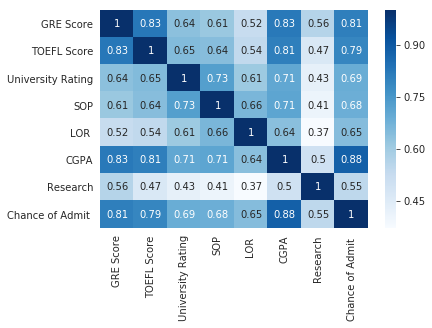

In [3]:
data_cor_heatmap = sns.heatmap(df.corr(),annot=True, cmap='Blues')


<br>

### Prior Distributions
I am going with a pretty standard Bayesian formulation almost the same as what was discussed in class, mainly to keep things simple. I am putting a normal prior on the vector of my regression weights, $\beta$ and a gamma prior on the inverse of the variance i.e. $1/\sigma^2$ of the Normal error distribution.

$f(\beta) = N(\beta_0, \Sigma_0)$ where

$\beta_0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]$ and $\Sigma_0$ is a diagonal matrix, diag(0.05, 0.1, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2)

My prior for $\beta_0$ reflects my belief that I do not know how the different independent variables affect the Chance of Admit, I assume each of them has some variance with no covariance between any variables. I assigned a lower variance to the GRE and TOEFL score coefficients to account for their relative magnitudes.

<br>

$f(1/\sigma^2) = Gamma(\nu_0/2, \nu_0\sigma^2_0/2)$, where

$\nu_0 = 10$ and $\sigma^2_0 = 0.04$

My prior for the variance of the error term reflects my belief that the magnitudes should be fairly low on the order ~ 0.05
which is captured by the above parameters on the Gamma distribution for $1/\sigma^2$. Note in the distribution below the peak for $1/\sigma^2$ is around 20, so $sigma^2$ would be around 0.05

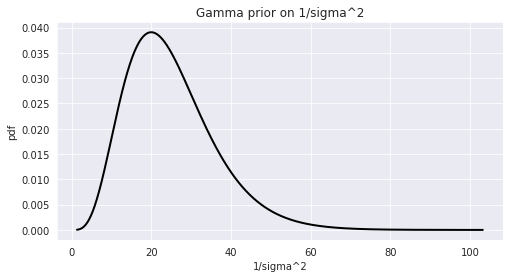

In [4]:
## Plot the univariate Gamma on 1/sigma^2
nu_0 = 10
sigma2_0 = 0.04
gamma_dist = scipy.stats.gamma(a = nu_0/2, scale = 2/(nu_0*sigma2_0))
x = np.linspace(gamma_dist.ppf(0.00001),
                gamma_dist.ppf(0.99999), 1000)
fig, axs = plt.subplots(1, figsize=(8, 4))
plot = axs.plot(x, gamma_dist.pdf(x), 'k-', lw=2, label='1/sigma^2 ~ Gamma(v0/2, sigma0^2/2)')
axs.set_title("Gamma prior on 1/sigma^2")
axs.set_xlabel("1/sigma^2")
foo = axs.set_ylabel("pdf")


<br>

### Posterior Distributions

Given the above Prior distribution our conditional posterior distributions look like :

$p(\beta|Y, X, \sigma^2) \sim N(\beta_*, \Sigma_*)$ &nbsp; &nbsp; &nbsp; where

$\beta_* = (\Sigma_0^{-1} + X^{T}X/\sigma^2)^{-1} (\Sigma_0^{-1}\beta_0 + X^{T}Y/\sigma^2)$ &nbsp; and &nbsp; $\Sigma_* = (\Sigma_0^{-1} + X^TX/\sigma^2)^{-1}$

<br>

$p(\sigma^2|Y, X, \beta) \sim Inv-Gamma((\nu_0 + n)/2, [\nu_0\sigma_0 + SSR(\beta)]/2)$ &nbsp; &nbsp; where

$SSR(\beta)$ is the sum of squared residuals given as : $SSR(\beta) = (Y - X\beta)^{T}(Y - X\beta)$

$n = 500$, i.e. the number of data points


<br>

### Gibbs Sampling of the Posteriors

We can now use Gibbs sampling to simulate parameters from our conditional posterior distributions. The code for doing this is below.

In [5]:
def gibbs(beta_0, cov_0, nu_0, sigma2_0, X, Y, nsamples = 10000):
    '''
    :param numpy array: beta_0: A 1 x mmean vector for Normal Prior on beta
    :param numpy array: cov_0: A m x m cov matrix for Normal Prior on beta
    :param float nu_0: parameter for Inverse-Gamma prior on 1/sigma^2
    :param float sigma2_0: parameter for Inverse-Gamma prior on 1/sigma^2
    :param numpy array: X: A n x m design matrix
    :param numpy array: Y: A n x 1 vector of response variables
    :param nsamples: no of samples to draw
    '''
    beta_samples = np.empty(shape = (nsamples, X.shape[1]))
    sigma2_samples = np.empty(nsamples)
    ssr_samples = np.empty(nsamples)
    
    ## initialize sigma2 to 1 / 2*nu_0 and beta to beta_0
    sigma2_samples[0] = 1 / (2*nu_0)
    beta_samples[0] = beta_0.flatten()
    
    ## want to keep track of ssr too
    temp = Y - np.matmul(X, beta_samples[0:1,:].T)
    ssr_samples[0] = np.matmul(temp.T, temp)[0][0]

    # These computations can be done outside the sampling loop - Once
    X_trans_Y = np.matmul(X.T, Y)
    X_trans_X = np.matmul(X.T, X)
    cov_0_inv = np.linalg.inv(cov_0)
    cov_0_inv_beta_0 = np.matmul(cov_0_inv, beta_0)
    
    shape_invgamma_post = (nu_0 + Y.shape[0]) / 2
    nu_0_sigma2_0 = nu_0 * sigma2_0

    for i in range(1, nsamples):

        ## First simulate beta from its conditional posterior dist
        # calculate cov_* and beta_* 
        # the variance and mean of the posterior distribution
        cov_post  = np.linalg.inv(cov_0_inv + X_trans_X / sigma2_samples[i - 1])
        mean_post = np.matmul(cov_post,
                              cov_0_inv_beta_0 + X_trans_Y / sigma2_samples[i - 1]).flatten()
        # draw beta from a MV Normal with above params
        beta_samples[i] = np.random.multivariate_normal(mean_post, cov_post, 1)[0]
        
        ## Now simulate sigma2 from its conditional posterior dist
        # SSR(beta)
        Y_minus_X_beta = Y - np.matmul(X, beta_samples[i:i+1,:].T)
        ssr_beta = np.matmul(Y_minus_X_beta.T, Y_minus_X_beta)[0][0]
        ssr_samples[i] = ssr_beta
        ## draw sigma2 from an inverse gamma
        sigma2_samples[i] = scipy.stats.invgamma.rvs(
            a = shape_invgamma_post, scale = 2 / (nu_0_sigma2_0 + ssr_beta), size = 1)

    return beta_samples, sigma2_samples, ssr_samples

In [6]:
## Setup design matrix and our vector of observations
temp = df[["GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA", "Research"]].to_numpy()
X = np.insert(temp, 0, 1, axis = 1)
Y = df[["Chance of Admit "]].to_numpy()
## Parameters for posterior
# beta
beta_0 = np.zeros(shape = (1, 8)).T
var_0 = np.array([0.05, 0.1, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2])
cov_0  = np.diag(var_0)
# sigma2
nu_0 = 10
sigma2_0 = 0.04

## Gibbs sampling
beta_samples, sigma2_samples, ssr_samples = gibbs(beta_0, cov_0, nu_0, sigma2_0, X, Y, 10000)

In [7]:
## Plot
def plot_hist(beta_samples, sigma2_samples):
    data_dict = {}
    regression_coef_labels = ["Intercept", "GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA", "Research"]
    for i in range(0, 8):
        beta_label = "beta_" + regression_coef_labels[i]
        data_dict[beta_label] = beta_samples[:, i]
    data_dict["sigma2"] = sigma2_samples
    beta_df = pd.DataFrame(data_dict)

    out_labels = ["beta_" + e for e in regression_coef_labels]
    out_labels.append("sigma2")
    fig, axs = plt.subplots(3, 3, figsize = (10, 10))
    j = 0
    i = 0
    for key in out_labels:
        if key == "sigma2":
            # inital point for Gibbs sampling was way different than in subsequent iterations
            foo = axs[i, j].hist(beta_df[key][1:], bins = 20)
        else:
            foo = axs[i, j].hist(beta_df[key], bins = 20)
        axs[i, j].set_xlabel(key)
        axs[i, j].set_ylabel("counts")
        if j == 2:
            j = 0
            i += 1
        else:
            j += 1
    title = fig.suptitle("Histogram of simulated regression coefficients and sigma2")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return beta_df

def plot_scatter(beta_df):
    ## Scatter plots of Gibbs sampling for beta_CGPA, beta_TOEFL, betea_GRE
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].scatter(beta_df["beta_GRE Score"], beta_df["beta_CGPA"], alpha=.1, s=50)
    axs[0, 0].set_xlabel("beta_GRE")
    axs[0, 0].set_ylabel("beta_CGPA")
    axs[0, 1].scatter(beta_df["beta_TOEFL Score"], beta_df["beta_CGPA"], alpha=.1, s=50)
    axs[0, 1].set_xlabel("beta_TOEFL")
    axs[0, 1].set_ylabel("beta_CGPA")
    axs[1, 0].scatter(beta_df["beta_GRE Score"], beta_df["beta_TOEFL Score"], alpha=.1, s=50)
    axs[1, 0].set_xlabel("beta_GRE")
    axs[1, 0].set_ylabel("beta_TOEFL")
    axs[1, 1].scatter(beta_df["beta_Research"], beta_df["beta_CGPA"], alpha=.1, s=50)
    axs[1, 1].set_xlabel("beta_Research")
    axs[1, 1].set_ylabel("beta_CGPA")
    title = fig.suptitle("Scatter plot for some simulated regression coefficients")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
def plot_hist_sigma2(beta_df):
    plt.figure(figsize=(3, 3))
    plt.hist(beta_df["sigma2"][1:], bins = 20)
    plt.xlabel("sigma2")
    foo = plt.ylabel("count")
    
def plot_ssr(ssr_samples):
    foo = plt.hist(ssr_samples[3:], bins = 20)
    plt.xlabel("Gibbs sampling - Sum of squared residuals")
    foo = plt.ylabel("Counts")

##### Results from Gibbs sampling

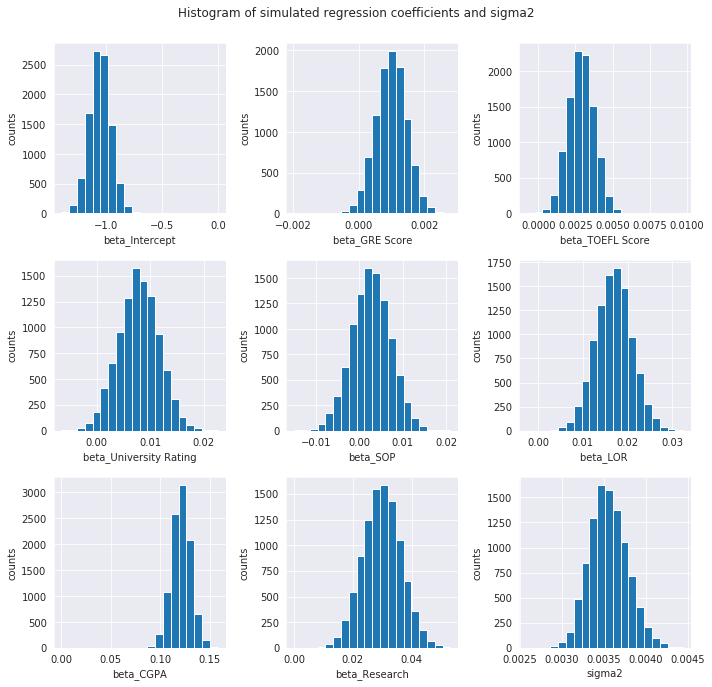

In [8]:
beta_df = plot_hist(beta_samples, sigma2_samples)

Simulated values of the variance of the error term, i.e. $\sigma^2$ are pretty small, an order of magnitude smaller than the initial value of 0.05 that I set for Gibbs sampling.

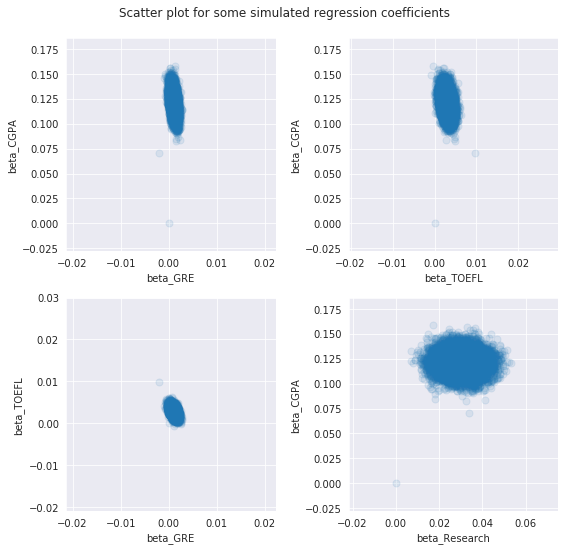

In [9]:
plot_scatter(beta_df)

My takeaway from the Gibbs sampling for the posterior distributions was :

**1.** CGPA seems to impact the predictions the most, this is evidenced by its higher regression coefficient relative to its scale of magnitude versus the other predictor variables. As expected since GRE and TOEFL scores are correlated with CGPA they have a lower impact on the Chance of Admit. For e.g. a 30 point increase in GRE Score (in isolation w.r.t to other variables) could have a ~ 30 * 0.001 = 0.03 increased Chance of Admit. In contrast a 1 point increase in CGPA can lead to more than 0.10 increase in Chance of Admit.

**2.** Research was the next biggest contributor to the outcome variable, this can be explained by the fact that it was the variable least correlated with any of the other predictor variables.

**3.** The variance of the error term has a lower magnitude than what I initially anticipated and expressed in my prior. This would imply my residuals are a bit on the higher side. I plotted a histogram below.

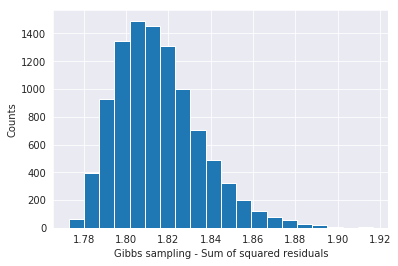

In [10]:
plot_ssr(ssr_samples)

#### Comparison to classical linear regression model
To get a sense of the regression coefficients obtained using Gibbs sampling, I did a simple ordinary least squares regression and found that the numbers are pretty comparable, infact most of the coef values below are very close to the peak of the respective simulated distributions.

In [11]:
import statsmodels.api as sm
Y = df["Chance of Admit "]
X = df[["GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA", "Research"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     324.4
Date:                Mon, 03 Aug 2020   Prob (F-statistic):          8.21e-180
Time:                        13:17:33   Log-Likelihood:                 701.38
No. Observations:                 500   AIC:                            -1387.
Df Residuals:                     492   BIC:                            -1353.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2757      0.10

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)



<br>

### Sensitivity Analysis

To see how my prior affects the results, I changed the parameters for the prior distribution on the regression coefficients. I updated the variance on CGPA to be 100 times lower while letting its coefficient remain 0. This would imply I am stating strongly in my prior that CGPA should not affect the Chance of Admit.

From the plots below it seems like this this had only a minor impact on the posterior results. The values from Gibbs simulation on the new posterior is similar to the previous results.

In [12]:
## Setup design matrix and our vector of observations
temp = df[["GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR ", "CGPA", "Research"]].to_numpy()
X = np.insert(temp, 0, 1, axis = 1)
Y = df[["Chance of Admit "]].to_numpy()
## Parameters for posterior
# beta
beta_0 = np.zeros(shape = (1, 8)).T
var_0 = np.array([0.05, 0.1, 0.2, 0.2, 0.2, 0.2, 0.002, 0.2])
cov_0  = np.diag(var_0)
# sigma2
nu_0 = 10
sigma2_0 = 0.04

## Gibbs sampling
beta_samples, sigma2_samples, ssr_samples = gibbs(beta_0, cov_0, nu_0, sigma2_0, X, Y, 10000)

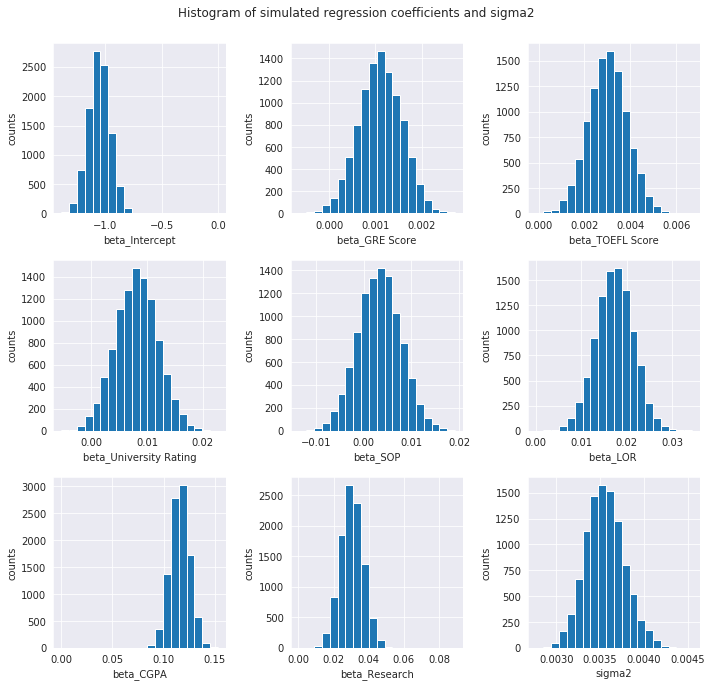

In [13]:
beta_df = plot_hist(beta_samples, sigma2_samples)

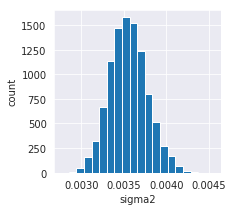

In [14]:
plot_hist_sigma2(beta_df)

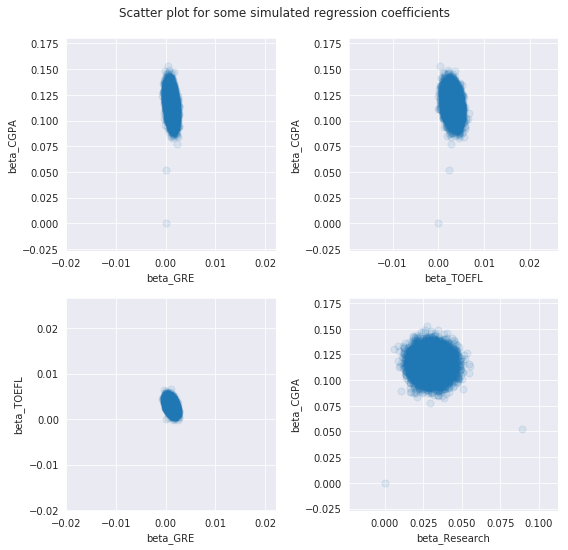

In [15]:
plot_scatter(beta_df)

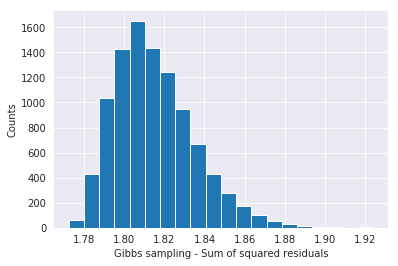

In [16]:
plot_ssr(ssr_samples)